In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import re

pd.set_option("max_colwidth", 75)

In [2]:
all_cards_raw = pd.read_csv('card_information.csv')

In [3]:
all_cards_raw.isnull().sum()

Card Material       0
Card Type          21
Category           21
Cost               25
Description        36
Element            23
Job               360
Median            191
Name                0
Number              0
Power            1722
Rarity              0
TCG               220
URL                 0
set                 0
dtype: int64

In [4]:
# Output obs with missing card data
missing_cols = ['Card Type','Category','Cost','Element']

all_cards_raw[all_cards_raw[missing_cols].isnull().any(axis=1)].drop_duplicates(subset=['Description','Number']).drop(columns='Card Material').to_csv('missing card values.csv',index=False)
# all_cards_raw[all_cards_raw['Number']=="A-003"].to_csv('one last missing card.csv',index=False)

In [5]:
update_cols = ['Card Type','Category','Cost','Element','Job','Power']

manual_entry_raw = pd.read_csv("missing card values_manual fill.csv")
manual_entry = manual_entry_raw[['Description','URL','set','No Game Info/Price']+ update_cols]

all_cards_filled = all_cards_raw.merge(manual_entry,on=['Description','URL','set'],how='outer',validate='m:1',indicator=True)
all_cards_filled[all_cards_filled['_merge']=="both"]

for col in update_cols:
    all_cards_filled[col] = all_cards_filled[col+"_x"].fillna(all_cards_filled[col+"_y"])
    all_cards_filled.drop([col+"_x",col+"_y"], 1, inplace=True)    

print("Check that updated values are accurate:")
all_cards_filled[all_cards_filled['_merge']=="both"].drop_duplicates(subset=['Description'])[['Name']+update_cols]

Check that updated values are accurate:


,Name,Card Type,Category,Cost,Element,Job,Power
1336,Gladiolus,Forward,XV,4.0,Earth,Retainer,9000.0
1858,Steiner EX - 3-137R,Forward,IX,5.0,Water,Knight,6000.0
2433,Volker,Forward,XI,4.0,Fire,Warrior,8000.0
2681,Red Mage,Backup,III,2.0,Fire,Standard Unit,NaN
2767,Arecia Al-Rashia,Backup,Type-0,3.0,Lightning,Archsorceress,NaN
2967,Quina,Forward,IX,4.0,Water,Blue Mage,5000.0
3093,Cloud - A-001,NaN,NaN,NaN,NaN,NaN,NaN
3101,Dissidia 3rd Anniversary - A-002,NaN,NaN,NaN,NaN,NaN,NaN
3119,Golbez/Cecil - A-004,NaN,NaN,NaN,NaN,NaN,NaN
3127,Kain - PR-009/2-103H (Alternate Art Promo),Forward,Dissidia IV,3.0,Lightning,Dragoon,5000.0


In [6]:
# Output observations where there is no price data
# Based on spot checking URLs, conclude that price data is not available for these cards
missing_prices = all_cards_filled[all_cards_filled['TCG'].isnull()]
missing_prices.to_csv('missing prices.csv',index=False)
missing_prices.sample(n=3)


,Card Material,Description,Median,Name,Number,Rarity,TCG,URL,set,No Game Info/Price,_merge,Card Type,Category,Cost,Element,Job,Power
1970,Foil,"[Dull], put Illusionist into the Break Zone: Choose 1 Forward. It must ...",0.42,Illusionist,6-005C,Common,NaN,https://shop.tcgplayer.com/final-fantasy-tcg/opus-vi/illusionist,Opus VI,NaN,left_only,Backup,FFTA2,2.0,Fire,Standard Unit,NaN
1565,Foil,[I][Dull]: Choose 1 Dull Forward. Deal it 2000 damage.,0.25,Black Mage (7-028C),7-028C,Common,NaN,https://shop.tcgplayer.com/final-fantasy-tcg/opus-vii/black-mage-7-028c,Opus VII,NaN,left_only,Backup,V,2.0,Ice,Standard Unit,NaN
840,Normal,EX BURST Deal 2000 damage to all the active Forwards opponent controls....,NaN,Raiden (REVENANT WINGS) EX (Full Art),10-100C,Common,NaN,https://shop.tcgplayer.com/final-fantasy-tcg/opus-x/raiden-revenant-win...,Opus X,NaN,left_only,Summon,XII,1.0,Lightning,NaN,NaN


In [7]:
# Take only observations with non-missing TCG Price to create regression dataset
# and finish feature handling
all_cards_reg = all_cards_filled[~all_cards_filled[['TCG']].isnull().any(axis=1)]

# Drop cards with no game info
all_cards_reg = all_cards_reg.drop(columns=['No Game Info/Price','_merge'])

# Drop cards with no game info
all_cards_reg = all_cards_reg.rename(columns={'TCG':'TCG Market Price'})

# Fill NaN Descriptions with empty string
all_cards_reg['Description'] = all_cards_reg['Description'].fillna('')

# Generate description Length
all_cards_reg['Desc Length'] = all_cards_reg['Description'].str.len()

# Replace NaN's in Power Variable to 0
all_cards_reg.loc[all_cards_reg['Power'].isnull(),['Power']] = 0

# Generate Full Art flag indicating that a card is full art
all_cards_reg['Full Art'] =0
all_cards_reg.loc[all_cards_reg['Name'].str.contains('Full Art'),'Full Art']=1

# Generate number of abilities, indicated from a card's description by the number of ':' found
all_cards_reg['Ability Count']=all_cards_reg['Description'].str.count(':')

# Generate flag for EX BURST, indicating that a card has an ability that takes an instant effect
all_cards_reg['Has EX Burst'] =0
all_cards_reg.loc[all_cards_reg['Description'].str.contains('EX BURST',case=False),'Has EX Burst']=1

# Log Cost variable  
all_cards_reg['log(Cost)']=np.log(all_cards_reg['Cost']) 

In [8]:
print("There are",len(all_cards_reg),"obs in the master regression dataset.")
all_cards_reg.isnull().sum()

There are 3725 obs in the master regression dataset.


Card Material         0
Description           0
Median               64
Name                  0
Number                0
Rarity                0
TCG Market Price      0
URL                   0
set                   0
Card Type             0
Category              0
Cost                  0
Element               0
Job                 326
Power                 0
Desc Length           0
Full Art              0
Ability Count         0
Has EX Burst          0
log(Cost)             0
dtype: int64

In [9]:
len(all_cards_reg['set'].unique())

14

# Training Split and EDA

In [10]:
from sklearn.model_selection import train_test_split
import matplotlib as plt
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab
import seaborn as sns

In [13]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.set(font_scale=2.5)

formatter = ticker.FormatStrFormatter('$%1.2f') # to format Y-axis for Price

In [12]:
# X, y = cars.drop('price',axis=1), cars['price']
x_cat_vars = ['Card Material','Rarity','Category','Element','set',]
x_flag_vars = ['Has EX Burst', 'Full Art',]
x_num_vars = ['Desc Length','log(Cost)','Ability Count','Power',]
x_vars = x_cat_vars + x_flag_vars + x_num_vars
X, y = all_cards_reg[x_vars], all_cards_reg['TCG Market Price']

# hold out 20% of the total data for final testing
X_raw, X_test_raw, y_, y_test = train_test_split(X, y, test_size=.2, random_state=10)

df_raw = X_raw.join(y_)

len(df_raw)

2980

In [15]:
df_raw.head()

,Card Material,Rarity,Category,Element,set,Has EX Burst,Full Art,Desc Length,log(Cost),Ability Count,Power,TCG Market Price
3588,Foil,Common,VII,Fire,Opus I,0,0,110,0.693147,0,4000.0,26.70
3193,Normal,Promo,Dissidia I,Water,FF: Promo Cards,0,0,77,1.386294,0,8000.0,3.48
2249,Normal,Hero,Mobius,Ice,Opus V,0,0,203,1.098612,0,0.0,0.51
946,Normal,Hero,VII,Fire,Opus X,0,0,216,1.386294,0,8000.0,0.36
656,Normal,Common,Special,Ice,Opus X,0,0,110,0.693147,1,0.0,0.11


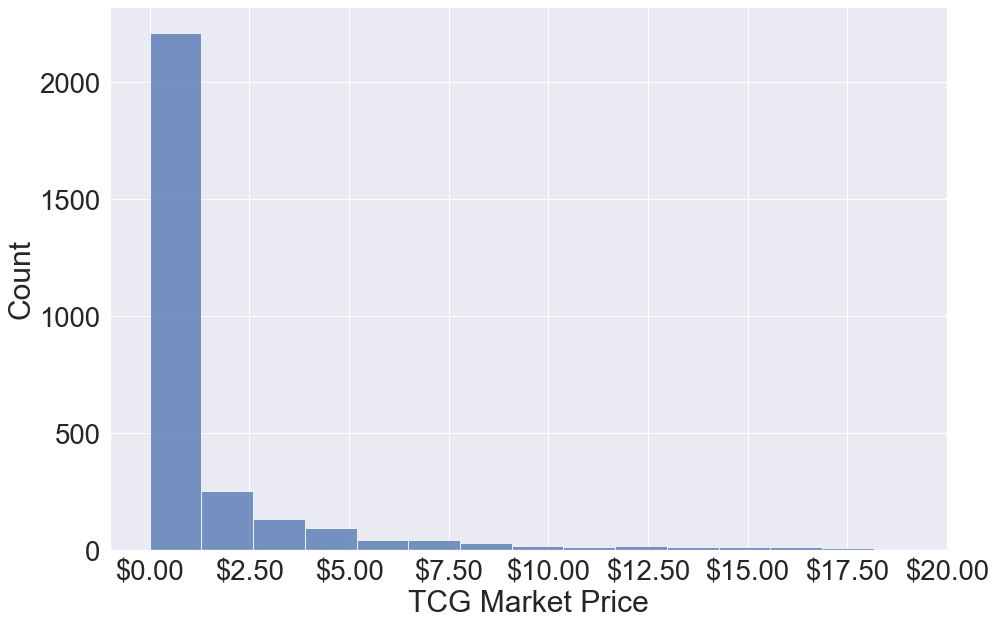

In [16]:
ax0 = sns.histplot(data=df_raw,x='TCG Market Price',bins=100)
ax0.set(xlim=(-1,20))
ax0.xaxis.set_major_formatter(formatter)

plt.pyplot.savefig('price histogram.svg')

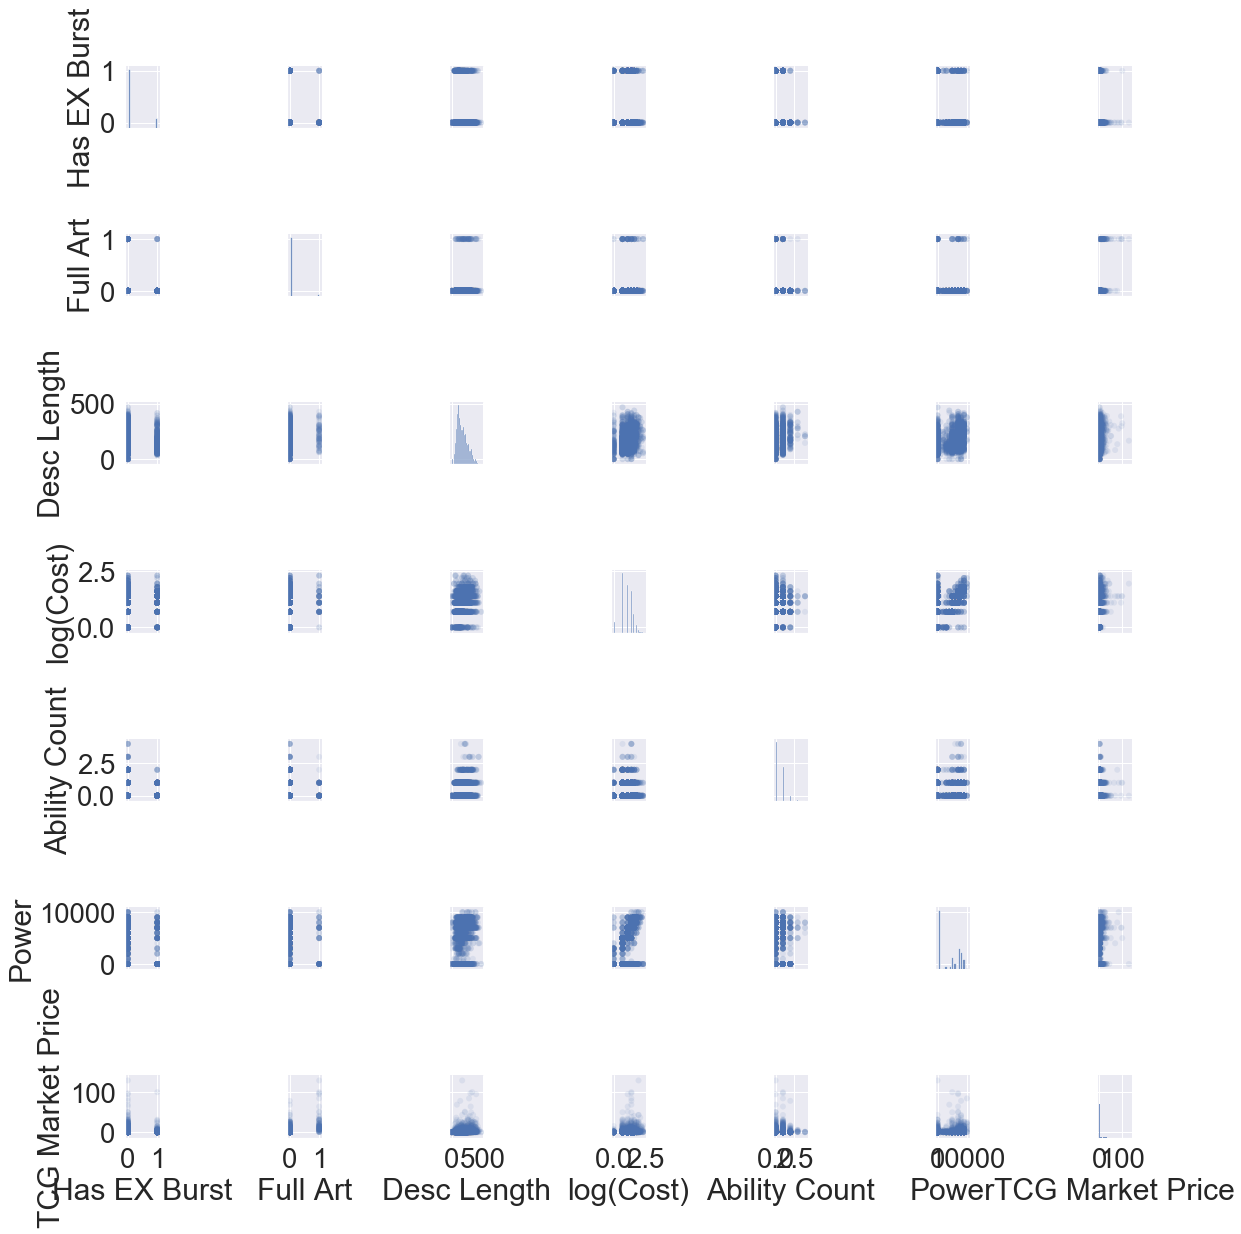

In [529]:
sns.pairplot(df_raw, plot_kws=dict(alpha=.1, edgecolor='none'));

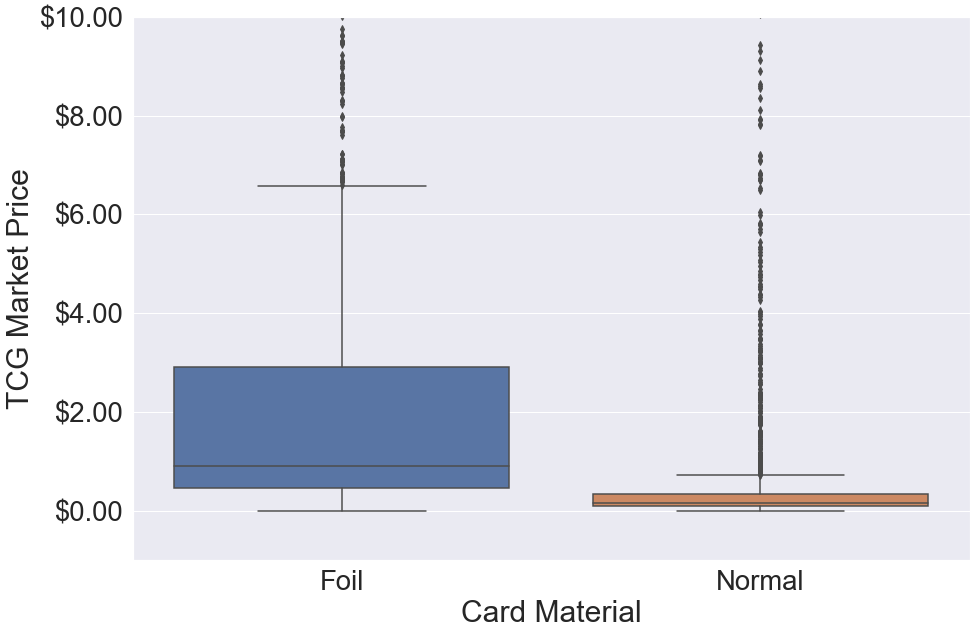

In [530]:
ax1 = sns.boxplot(x='Card Material',y='TCG Market Price',data=df_raw);
ax1.set(ylim=(-1,10))
ax1.yaxis.set_major_formatter(formatter)

[(-1, 40)]

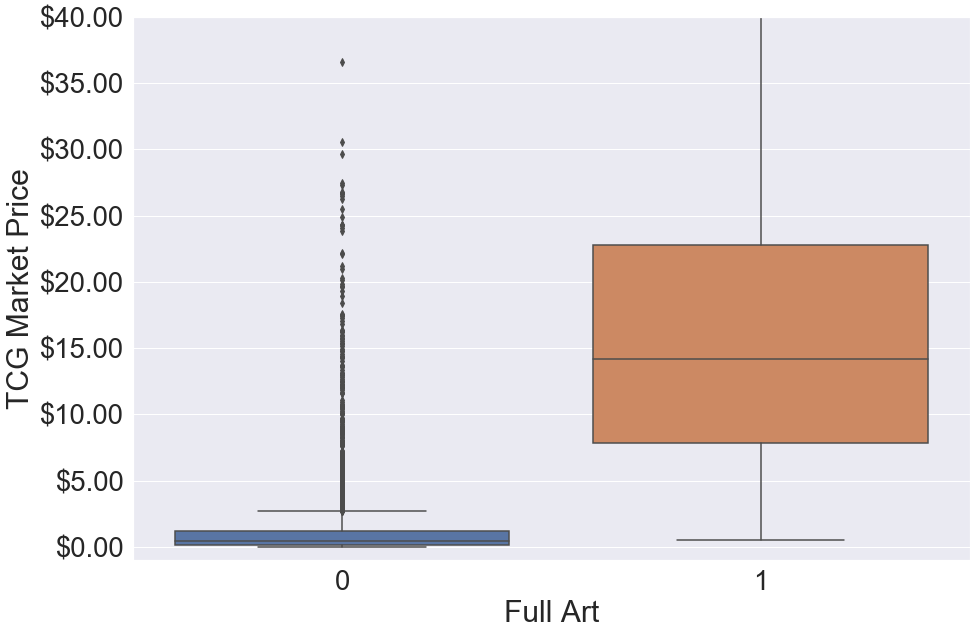

In [531]:
ax2 = sns.boxplot(x='Full Art',y='TCG Market Price',data=df_raw)
ax2.yaxis.set_major_formatter(formatter)
ax2.set(ylim=(-1,40))

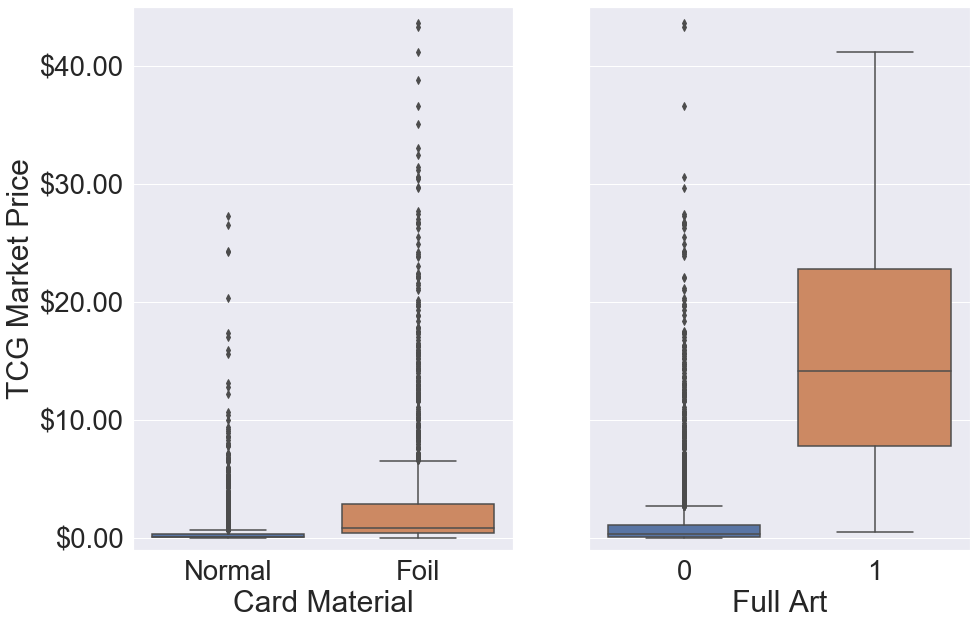

In [17]:
fig, axs0 = plt.pyplot.subplots(ncols=2,sharey=True)
sns.boxplot(x='Full Art',y='TCG Market Price',data=df_raw,ax=axs0[1])
sns.boxplot(x='Card Material',y='TCG Market Price',data=df_raw,ax=axs0[0], order=['Normal','Foil'])
axs0[0].yaxis.set_major_formatter(formatter)
y_ax_label_1 = axs0[1].axes.get_yaxis().get_label()
y_ax_label_1.set_visible(False)
axs0[0].set(ylim=(-1,45))
plt.pyplot.savefig('art boxplot.svg')

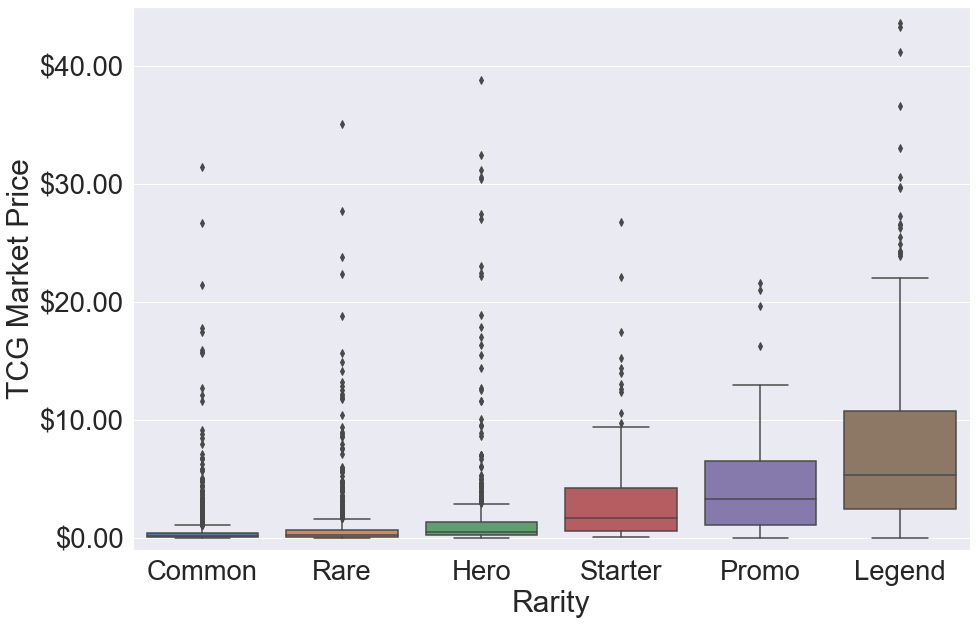

In [18]:
ax3 = sns.boxplot(x='Rarity',y='TCG Market Price',data=df_raw,order=['Common','Rare','Hero','Starter','Promo','Legend']);

ax3.yaxis.set_major_formatter(formatter)
ax3.set(ylim=(-1,45));
plt.pyplot.savefig('rarity boxplot.svg')

[(0, 4)]

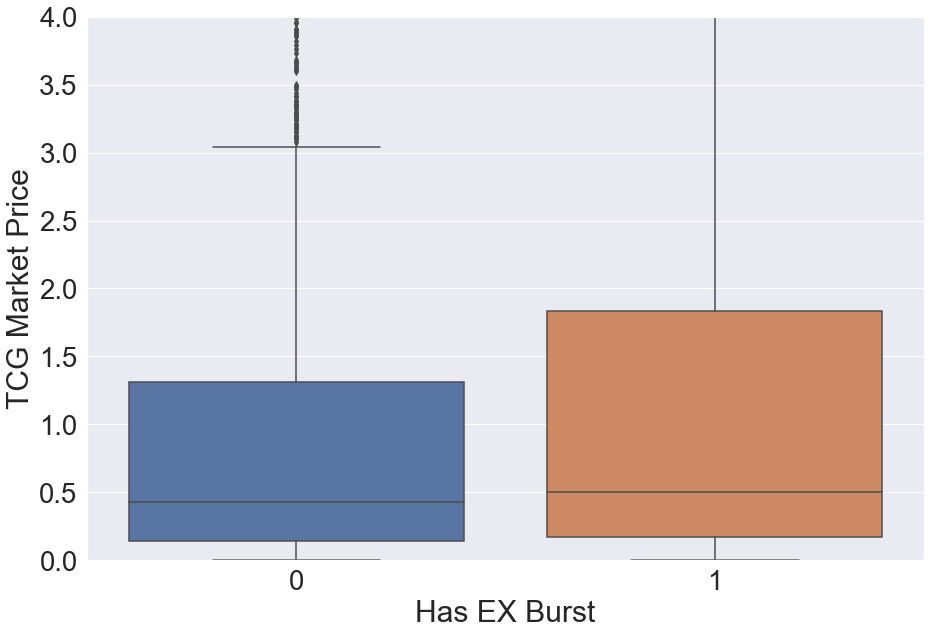

In [19]:
ax4 = sns.boxplot(x='Has EX Burst',y='TCG Market Price',data=df_raw);
ax4.set(ylim=(0,4))

[(0, 15)]

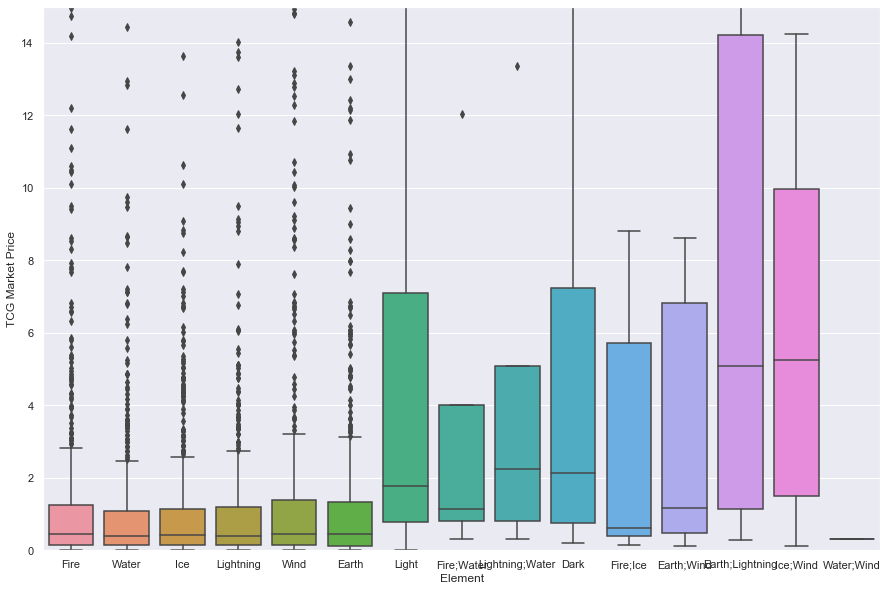

In [25]:
sns.set(font_scale=1)

ax5 = sns.boxplot(x='Element',y='TCG Market Price',data=df_raw);
ax5.set(ylim=(0,15))

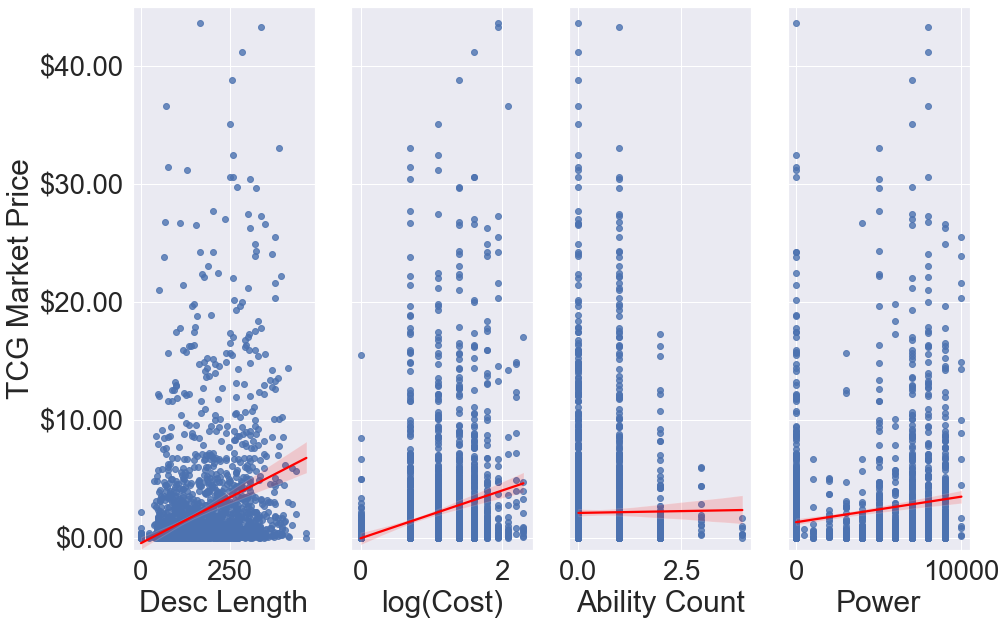

In [535]:
fig, axs1 = plt.pyplot.subplots(ncols=4,sharey=True)
sns.regplot(x='Desc Length', y='TCG Market Price', line_kws={"color": "red"}, data=df_raw, ax=axs1[0])
sns.regplot(x='log(Cost)', y='TCG Market Price', line_kws={"color": "red"}, data=df_raw, ax=axs1[1])
sns.regplot(x='Ability Count', y='TCG Market Price', line_kws={"color": "red"}, data=df_raw, ax=axs1[2])
sns.regplot(x='Power', y='TCG Market Price', line_kws={"color": "red"}, data=df_raw, ax=axs1[3])

axs1[0].yaxis.set_major_formatter(formatter)
axs1[0].set(ylim=(-1,45))
axs1[3].set(xlim=(-500,10500))

for i in range(1,4):
    axs1[i].axes.get_yaxis().get_label().set_visible(False)
    
plt.pyplot.savefig('card attributes regplot.svg')

# Validation
#### Preprocessing of Dummy Vars

In [297]:
def create_X_vars(df):
    """
    takes in a training/validation/test dataset for the regression
    and returns a dataframe that joins the numerical variables with
    the dummy variables converted from categorical variables
    """
    x_cat_vars = ['Card Material','Rarity','set',] # Removed Element, Category
    x_flag_vars = ['Full Art', "Has EX Burst",] 
    x_num_vars = ['log(Cost)','Ability Count','Power','Desc Length',]

    X_ = df[x_flag_vars+x_num_vars]
#     X_ = df[x_flag_vars]
#     for col in x_num_vars:
#         if col in ['Cost']:
#             X_.join(np.log(df[col]))
#         else:
#             X_.join(df[col])
    for col in x_cat_vars:
        if col == 'Element':
            cleaned = df['Element'].str.split(';',expand=True).stack()
            dummies = pd.get_dummies(cleaned).groupby(level=0).sum()
        else:
            dummies = pd.get_dummies(df[col],drop_first=True)

        X_ = X_.join(dummies)

    return X_

In [298]:
X_=create_X_vars(X_raw)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

In [299]:
X_test = create_X_vars(X_test_raw)

In [520]:
X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape

((2235, 25), (2235,), (745, 25), (745,), (745, 25), (745,))

In [425]:
X_.corr()[['Full Art', 'Has EX Burst', 'log(Cost)', 'Ability Count', 'Power','Desc Length', 
           'Normal', 'Hero', 'Legend', 'Promo', 'Rare', 'Starter']]

,Full Art,Has EX Burst,Cost,Ability Count,Power,Desc Length,Normal,Hero,Legend,Promo,Rare,Starter
Full Art,1.000000,-0.013571,0.043381,-0.023724,0.019943,0.107711,-0.133899,0.038893,0.087719,0.067725,-0.029306,-0.022279
Has EX Burst,-0.013571,1.000000,0.060881,-0.137215,-0.141948,-0.039702,0.003022,-0.028798,-0.069227,0.029169,0.046106,0.040178
Cost,0.043381,0.060881,1.000000,-0.082682,0.435235,0.280820,0.000852,0.197941,0.270776,0.067996,-0.023171,0.024960
Ability Count,-0.023724,-0.137215,-0.082682,1.000000,-0.045943,0.222460,0.002223,0.017250,0.079395,0.031748,-0.047249,-0.010340
Power,0.019943,-0.141948,0.435235,-0.045943,1.000000,0.348506,0.002664,0.143471,0.305032,0.082702,-0.050583,0.045692
Desc Length,0.107711,-0.039702,0.280820,0.222460,0.348506,1.000000,-0.022478,0.166300,0.380688,0.073875,-0.058242,0.062023
Normal,-0.133899,0.003022,0.000852,0.002223,0.002664,-0.022478,1.000000,-0.002685,-0.020748,-0.020901,0.013883,-0.020235
Hero,0.038893,-0.028798,0.197941,0.017250,0.143471,0.166300,-0.002685,1.000000,-0.166234,-0.057215,-0.302527,-0.115587
Legend,0.087719,-0.069227,0.270776,0.079395,0.305032,0.380688,-0.020748,-0.166234,1.000000,-0.038528,-0.203719,-0.077835
Promo,0.067725,0.029169,0.067996,0.031748,0.082702,0.073875,-0.020901,-0.057215,-0.038528,1.000000,-0.070117,-0.026790


### Validate

In [303]:
# Import libraries for regression modelling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV

#### Feature Transformations

In [332]:
poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias = False)
s = StandardScaler(with_mean=False)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)
X_test_poly = poly.fit_transform(X_test)

X_train_poly_scaled = s.fit_transform(X_train_poly)
X_val_poly_scaled = s.fit_transform(X_val_poly)
X_test_poly_scaled = s.fit_transform(X_test_poly)

In [305]:
X_train_poly_scaled.shape

(2235, 325)

#### Linear Regression: Normal Features

In [493]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print(f'Linear Regression on Training Data R^2: {reg.score(X_train, y_train)}')
print(f'Linear Regression on Validation Data R^2: {reg.score(X_val, y_val)}')

Linear Regression on Training Data R^2: 0.41575545253597246
Linear Regression on Validation Data R^2: 0.4204576153833922


In [492]:
from statsmodels.api import OLS
OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    TCG   R-squared (uncentered):                   0.476
Model:                            OLS   Adj. R-squared (uncentered):              0.470
Method:                 Least Squares   F-statistic:                              80.32
Date:                Fri, 22 Jan 2021   Prob (F-statistic):                   9.79e-288
Time:                        03:40:59   Log-Likelihood:                         -6716.3
No. Observations:                2235   AIC:                                  1.348e+04
Df Residuals:                    2210   BIC:                                  1.363e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Full Art           16.6473      0.647     25.714      0.000      15.378      17.917
Has EX Burst        0.2118      0.309      0.685      0.493      -0.394       0.818
Cost                0.0267      0.267      0.100      0.920      -0.497       0.550
Ability Count      -0.2036      0.173     -1.175      0.240      -0.543       0.136
Power           -5.848e-05   3.52e-05     -1.660      0.097      -0.000    1.06e-05
Desc Length         0.0013      0.002      0.806      0.420      -0.002       0.004
Normal             -1.8307      0.206     -8.870      0.000      -2.235      -1.426
Hero                0.7081      0.331      2.137      0.033       0.058       1.358
Legend              8.1058      0.446     18.159      0.000       7.230       8.981
Promo               4.5498      1.348      3.374      0.001       1.906       7.194
Rare                0.3419      0.275      1.243      0.214      -0.198       0.881
Starter             1.8248      0.514      3.547      0.000       0.816       2.834
FF: Promo Cards    -0.4779      0.888     -0.538      0.590      -2.219       1.263
Opus I              3.0004      0.418      7.175      0.000       2.180       3.820
Opus II             1.0918      0.468      2.332      0.020       0.174       2.010
Opus III            0.9903      0.473      2.095      0.036       0.063       1.917
Opus IV             0.7577      0.470      1.613      0.107      -0.164       1.679
Opus IX             0.8673      0.525      1.654      0.098      -0.161       1.896
Opus V              0.9618      0.480      2.003      0.045       0.020       1.903
Opus VI             1.4108      0.516      2.734      0.006       0.399       2.423
Opus VII            1.4034      0.507      2.770      0.006       0.410       2.397
Opus VIII           1.7009      0.492      3.454      0.001       0.735       2.667
Opus X              0.9695      0.496      1.953      0.051      -0.004       1.943
Opus XI             1.5154      0.512      2.960      0.003       0.512       2.519
Opus XII            2.5347      0.517      4.898      0.000       1.520       3.550
==============================================================================
Omnibus:                     3480.967   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2370328.276
Skew:                           9.530   Prob(JB):                         0.00
Kurtosis:                     161.398   Cond. No.                     7.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+04. This might

#### Linear Regression: Polynomial Features

In [322]:
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

print(f'Poly Regression on Training Data R^2: {reg.score(X_train_poly, y_train)}')
print(f'Poly Regression on Validation Data R^2: {reg.score(X_val_poly, y_val)}')

Poly Regression on Training Data R^2: 0.6247834098821026
Poly Regression on Validation Data R^2: 0.5049139912265036


#### Lasso Regression

In [318]:
m_lasso = LassoCV()
m_lasso.fit(X_train_poly_scaled,y_train)

print(f'LASSO Regression on Training Data R^2: { m_lasso.score(X_train_poly_scaled,y_train)}')
print(f'LASSO Regression on Validation Data R^2: { m_lasso.score(X_val_poly_scaled,y_val)}')

C:\Users\wlee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LASSO Regression on Training Data R^2: 0.5539523819333492
LASSO Regression on Validation Data R^2: 0.5476677685117314


#### Ridge Regression

710.6


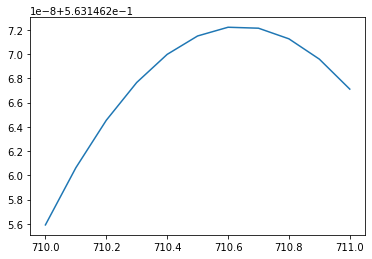

In [319]:
# Identify optimal alpha for Ridge Regression 

my_a= []
my_r2 = []
for a in np.linspace(710,711,11):
    m_ridge = RidgeCV(alphas=[a])
    m_ridge.fit(X_train_poly_scaled,y_train)
    my_a.append(m_ridge.alpha_)
    my_r2.append(m_ridge.score(X_val_poly_scaled,y_val))

max_index = my_r2.index(max(my_r2))
my_a[max_index]

print(my_a[max_index])
plt.pyplot.plot(my_a,my_r2)

In [486]:
m_ridge = RidgeCV(alphas=[710.6])
m_ridge.fit(X_train_poly_scaled,y_train)
print(f'Ridge Regression on Training Data R^2: { m_ridge.score(X_train_poly_scaled,y_train)}')
print(f'Ridge Regression on Validation Data R^2: { m_ridge.score(X_val_poly_scaled,y_val)}')

Ridge Regression on Training Data R^2: 0.5701629778079961
Ridge Regression on Validation Data R^2: 0.563146272206088


In [490]:
print(f'Linear Regression on Validation Data R^2: {reg.score(X_val, y_val)}')
print(f'Poly Regression on Validation Data R^2: {poly_reg.score(X_val_poly, y_val)}')
print(f'LASSO Regression on Validation Data R^2: { m_lasso.score(X_val_poly_scaled,y_val)}')
print(f'Ridge Regression on Validation Data R^2: { m_ridge.score(X_val_poly_scaled,y_val)}')
print()
print('Choosing Ridge Regression')

Linear Regression on Validation Data R^2: 0.4204576153833922
Poly Regression on Validation Data R^2: 0.5049139912265036
LASSO Regression on Validation Data R^2: 0.5476677685117314
Ridge Regression on Validation Data R^2: 0.563146272206088

Choosing Ridge Regression


## Model Performance!

In [491]:
print(f'Linear Regression on Test Data R^2: {reg.score(X_test, y_test)}')
print(f'Poly Regression on Test Data R^2: {poly_reg.score(X_test_poly, y_test)}')
print(f'LASSO Regression on Test Data R^2: { m_lasso.score(X_test_poly_scaled,y_test)}')
print(f'Ridge Regression on Test Data R^2: { m_ridge.score(X_test_poly_scaled,y_test)}')

Linear Regression on Test Data R^2: 0.315888918680442
Poly Regression on Test Data R^2: 0.4377195126102563
LASSO Regression on Test Data R^2: 0.46148380538095024
Ridge Regression on Test Data R^2: 0.4599689616048639


In [495]:
y_test_pred = m_ridge.predict(X_test_poly_scaled)

print("MAE:", np.mean(np.abs(y_test_pred-y_test)))

MAE: 1.535414935809877


In [549]:
res = y_test_pred-y_test
res = res.reset_index(drop= True)

TypeError: 'str' object is not callable

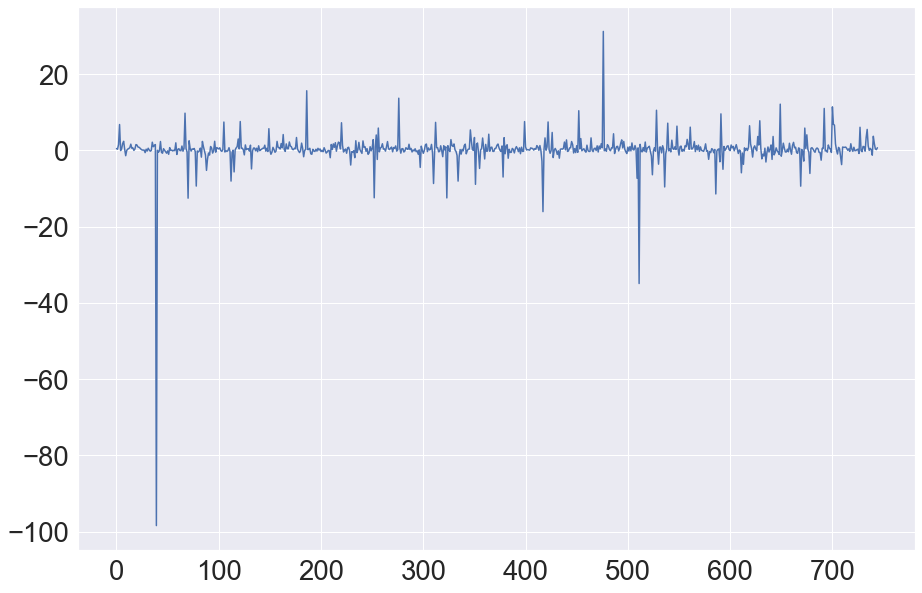

In [556]:
plt.pyplot.plot(res)
# ax47.axes.set_major_formatter(formatter)
# x_ax47_label = ax47.axes.get_yaxis().get_label()
# x_ax47_label.set_visible(False)
# ax47.set_ylabel('Predicted Price - True Price')

# plt.pyplot.ylabel('Predicted Price - True Price') 
plt.pyplot.savefig('Final Model Errors.svg')

In [552]:
coef_df = pd.DataFrame(list(zip(poly.get_feature_names(list(X_test.columns)),m_ridge.coef_)),columns=['Variable','Coefficient'])
coef_df['Absolute Coefficient'] = np.absolute(coef_df['Coefficient'])

coef_df.sort_values(by='Absolute Coefficient',ascending=False).to_csv('Model Coefficients.csv',index=False)
coef_df.sort_values(by='Absolute Coefficient',ascending=False).head(20)

,Variable,Coefficient,Absolute Coefficient
32,Full Art Legend,1.135081,1.135081
48,Full Art Opus XII,1.053864,1.053864
30,Full Art Normal,-0.668195,0.668195
0,Full Art,0.629332,0.629332
193,Legend Opus I,0.615195,0.615195
47,Full Art Opus XI,0.583761,0.583761
8,Legend,0.575495,0.575495
155,Normal Legend,-0.554751,0.554751
77,Cost Legend,0.546510,0.546510
203,Legend Opus XI,0.504020,0.504020


In [480]:
coef_df[coef_df['Variable'].isin(['Full Art', 'Has EX Burst', 'log(Cost)', 'Ability Count', 'Power','Desc Length', 
           'Normal', 'Hero', 'Legend', 'Promo', 'Rare', 'Starter'])]

,Variable,Coefficient,Absolute Coefficient
0,Full Art,0.629332,0.629332
1,Has EX Burst,0.011849,0.011849
3,Ability Count,-0.054975,0.054975
4,Power,-0.076623,0.076623
5,Desc Length,0.106266,0.106266
6,Normal,-0.187337,0.187337
7,Hero,0.052194,0.052194
8,Legend,0.575495,0.575495
9,Promo,0.065658,0.065658
10,Rare,0.056228,0.056228
